## 1. Set-up

In [ ]:
# mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# data manipulation
import numpy as np
import pandas as pd

# image processing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential

# sklearn utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr

# set up random seed
import random
seed = 24
tf.random.set_seed(seed)

# customize printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 200)

In [ ]:
# environmental variables
TRAIN_DATA_PATH = '/content/gdrive/MyDrive/deep_learning/data/train'
VALID_DATA_PATH = '/content/gdrive/MyDrive/deep_learning/data/valid'

CLASS_NAMES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASS_NAMES)

Define utility functions
- training history plot
- confusion matrix

In [ ]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

In [ ]:
# source: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf, group_names=None,categories='auto', count=True,percent=False,cbar=True, 
                          xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,
                          cmap='Blues',title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
def error_analysis(model, test_data):
  plt.figure(figsize=(18,12))
  for image_batch,label_batch in test_ds.take(1):
      predictions = model.predict(image_batch)
      predictions = np.argmax(predictions, axis=-1)
      for i in range(0,len(predictions) if len(predictions)<12 else 12):
          plt.subplot(3,4,i+1)
          plt.imshow(image_batch[i].numpy().astype("uint32"))
          true_class = test_ds.class_names[np.argmax(label_batch[i])]
          predict_class = test_ds.class_names[predictions[i]]
          title = f"""True: {true_class}\n Predict: {predict_class}"""
          plt.title(title, color='g' if true_class==predict_class else 'r')
          plt.axis("off")

## 2. Load Data and Data Cleaning

TensorFlow has some strictness when dealing with image formats. Some times your data set may even run well with, for instance Torch but will generate a format error with Tf. Nonetheless, it is best practice to always carryout preprocessing on the images to ensure a robust, safe and standard model.

*Reference*:
- [Unknown image file format. One of JPEG, PNG, GIF, BMP required](https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required)

In [ ]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images

In [ ]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [ ]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [ ]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)

In [ ]:
# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)

In [ ]:
# check image quality 3
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(VALID_DATA_PATH)

In [ ]:
move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))

In [ ]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25837
6677


#### Load Data

We will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk. 
  - `image_dataset_from_directory` returns a `tf.data.Dataset` object, a tuple `(images, labels)`, where `images` has shape  is `(batch_size, image_size[0], image_size[1], num_channels)`. 
  - supported image formats: jpeg, png, bmp, gif

*Reference*:
- [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224 
BATCH_SIZE = 32
LABEL_MODE = 'categorical'  # labels: one-hot encoded, a float32 tensor of shape (batch_size, num_classes). loss: categorical_crossentropy
COLOR_MODE = 'rgb'
VALID_TEST_RATIO = 0.5

In [ ]:
# training set - expect 25,851 (25,837) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25837 files belonging to 11 classes.


In [ ]:
# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        directory=VALID_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed,
        validation_split = VALID_TEST_RATIO, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [ ]:
# audit - make sure validation and test sets are approximately follow same distribution
assert((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test does not match'

## 3. Data Preprocessing

#### Data Augmentation

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` during training (not `Model.evaluate` or `Model.predict`).

1) Using Keras preprocessing layers, such as`tf.keras.layers.RandomCrop`,`tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomTranslation`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomZoom`, `tf.keras.layers.RandomHeight`, `tf.keras.layers.RandomWidth`, `tf.keras.layers.RandomContrast`

2) Using `tf.image` methods, such as `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop`, and `tf.image.stateless_random*`.

*Reference*:
- [keras documentation: data_augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
- [image classification](https://www.tensorflow.org/tutorials/images/classification#setup)

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
      # layers.RandomHeight(0.2),
      # layers.RandomWidth(0.2),
    ], name = 'data_augmentation'
)

<Figure size 720x720 with 0 Axes>

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

(-0.5, 223.5, 223.5, -0.5)

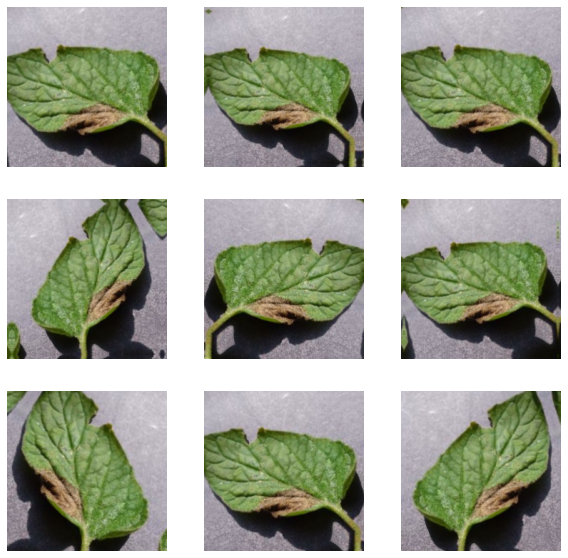

In [ ]:
# Visualize a few augmented examples by applying data augmentation to the same image several times:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Data Preprocessing

Image preprocessing layers : standardizing the inputs of an image model.

When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.


- `tf.keras.layers.Resizing`: resizes a batch of images to a target size.
- `tf.keras.layers.Rescaling`: rescales and offsets the values of a batch of image (e.g. go from inputs in the [0, 255] range to inputs in the [0, 1] range.
- `tf.keras.layers.CenterCrop`: returns a center crop of a batch of images.

*Reference*:
- [working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)

In [ ]:
preprocessing = keras.Sequential(
    [
      # layers.Resizing(IMG_HEIGHT, IMG_WIDTH), 
      layers.Rescaling((1./255), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # some pre-trained model requires [-1, 1] like MobileNet, I would pass `scale=1./127.5, offset=-1`      
    ], name='preprocessing'
)

## 4. Basic Custom CNN Model

*Reference*:
- [Conv2D Layer](https://keras.io/api/layers/convolution_layers/convolution2d/)
- [MaxPooling2D Layer](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
- [Dense Layer](https://keras.io/api/layers/core_layers/dense/)
- [Dropout Layer](https://keras.io/api/layers/regularization_layers/dropout/)
- [Global Average Pooling Layer](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/)
- [BatchNorm](https://keras.io/api/layers/normalization_layers/batch_normalization/)

Build Model

In [ ]:
# set up session
params = {'RANDOM_STATE':seed,
          'CONV_ACTIVATION':'relu',
          'DENSE_ACTIVATION':'gelu',
          'DENSE_KERNEL_INITIALIZER':'he_normal',
          'LEARNING_RATE':1e-04, 
          'DROPOUT_RATE': 0.25,
          'CONV2D_PADDING':'same',
          }

In [ ]:
keras.backend.clear_session()

model = tf.keras.Sequential([
    #data_augmentation,
    preprocessing,

    layers.Conv2D(filters=16, kernel_size=(5, 5), padding=params['CONV2D_PADDING'], activation= params['CONV_ACTIVATION']),
    layers.MaxPooling2D(pool_size=(3,3)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=32, kernel_size=(3, 3), padding=params['CONV2D_PADDING'], activation= params['CONV_ACTIVATION']),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), padding=params['CONV2D_PADDING'], activation= params['CONV_ACTIVATION']),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=128, kernel_size=(3, 3), padding=params['CONV2D_PADDING'], activation= params['CONV_ACTIVATION']),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(units=64, activation=params['DENSE_ACTIVATION'], kernel_initializer=params['DENSE_KERNEL_INITIALIZER']),
    layers.Dropout(rate=params['DROPOUT_RATE']),

    layers.Dense(len(train_ds.class_names), activation='softmax', name='output_layers')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0

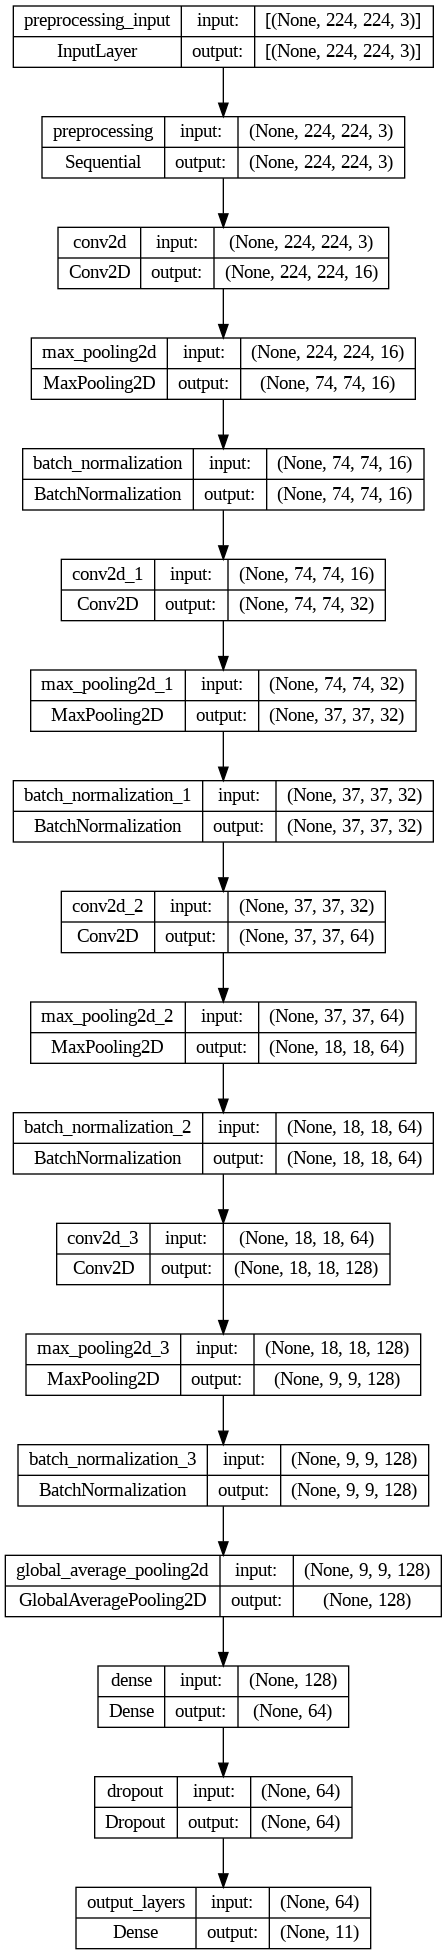

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Compile Model

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = params['LEARNING_RATE'])
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

Early Stopping

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=5, 
    verbose=1
)

Model Training

In [ ]:
EPOCHS = 35

history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = EPOCHS,
    callbacks = [early_stopping]
)



Epoch 1/35
808/808 [==============================] - 4248s 5s/step - loss: 1.4779 - accuracy: 0.5151 - val_loss: 1.1382 - val_accuracy: 0.6089
Epoch 2/35
808/808 [==============================] - 92s 113ms/step - loss: 1.0164 - accuracy: 0.6686 - val_loss: 0.9789 - val_accuracy: 0.6688
Epoch 3/35
808/808 [==============================] - 90s 111ms/step - loss: 0.8702 - accuracy: 0.7157 - val_loss: 0.9074 - val_accuracy: 0.6801
Epoch 4/35
808/808 [==============================] - 90s 111ms/step - loss: 0.7859 - accuracy: 0.7403 - val_loss: 0.6248 - val_accuracy: 0.7886
Epoch 5/35
808/808 [==============================] - 89s 110ms/step - loss: 0.7157 - accuracy: 0.7618 - val_loss: 0.7226 - val_accuracy: 0.7320
Epoch 6/35
808/808 [==============================] - 89s 110ms/step - loss: 0.6700 - accuracy: 0.7770 - val_loss: 0.5453 - val_accuracy: 0.8143
Epoch 7/35
808/808 [==============================] - 90s 110ms/step - loss: 0.6330 - accuracy: 0.7884 - val_loss: 0.5305 - val_acc

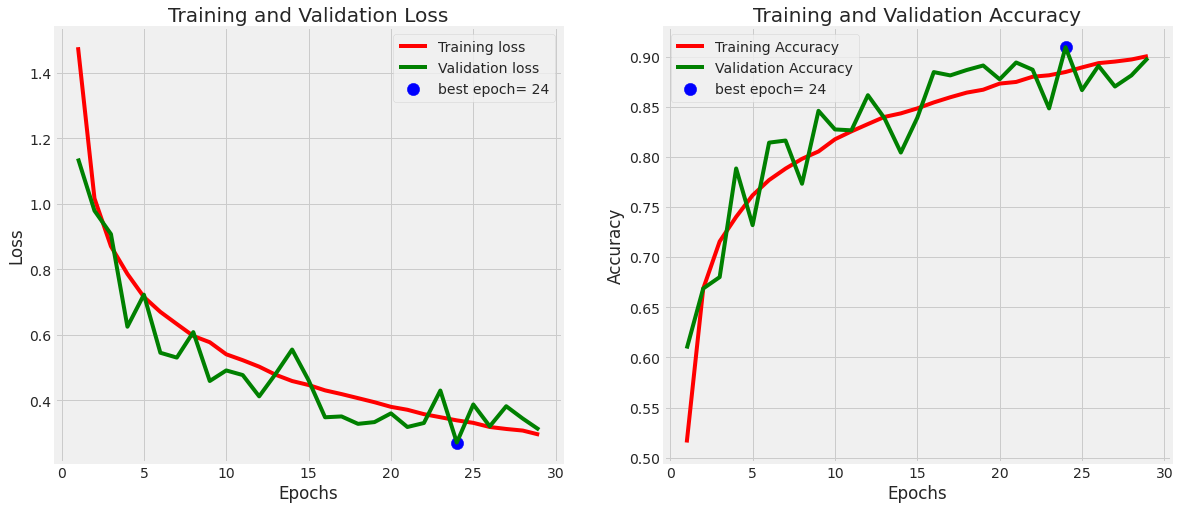

In [ ]:
plot_training(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

# test loss: 0.25463148951530457; test accuracy: 0.9167165756225586

105/105 [==============================] - 1149s 11s/step - loss: 0.2546 - accuracy: 0.9167


[0.25463148951530457, 0.9167165756225586]

In [ ]:
train_loss, train_accuracy = model.evaluate(train_ds)
valid_loss, valid_accuracy = model.evaluate(valid_ds)

# train loss: 0.24021269381046295; train accuracy: 0.9217401146888733
# validation loss: 0.2712972164154053; validation accuracy: 0.9095537662506104

808/808 [==============================] - 88s 107ms/step - loss: 0.2402 - accuracy: 0.9217


[0.24021269381046295, 0.9217401146888733]

105/105 [==============================] - 13s 112ms/step - loss: 0.2713 - accuracy: 0.9096


[0.2712972164154053, 0.9095537662506104]

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 167ms/step


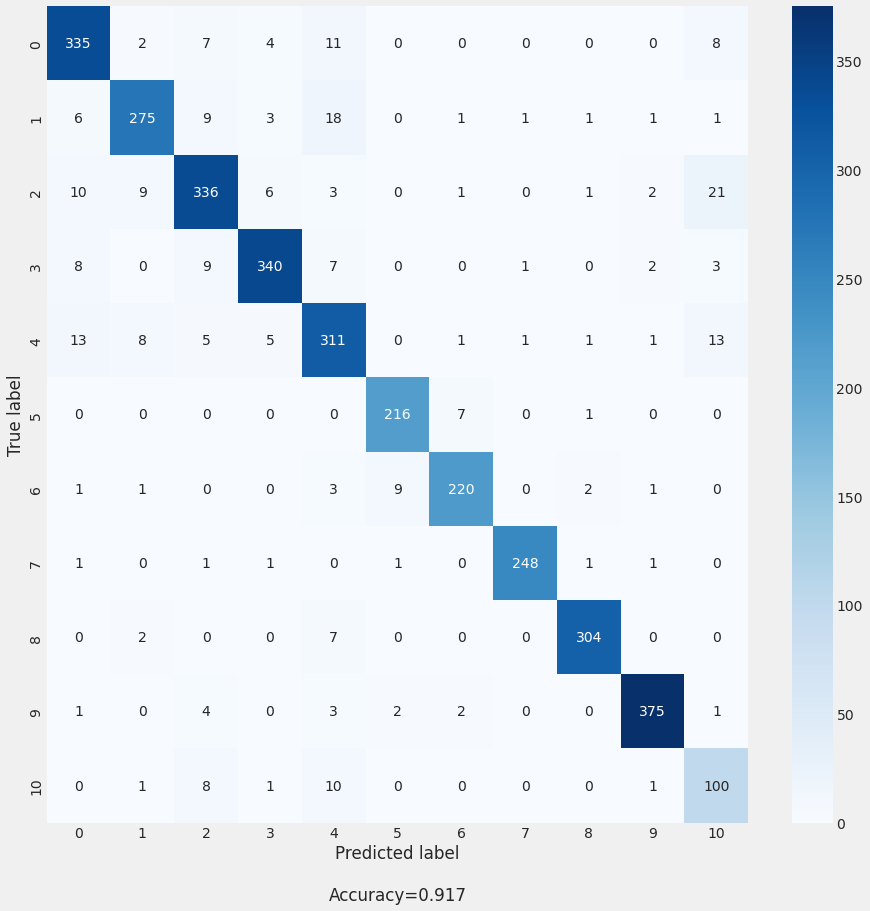

In [ ]:
cf = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf, test_ds.class_names,figsize=(14,14))

<Figure size 1296x864 with 0 Axes>

1/1 [==============================] - 0s 30ms/step


<AxesSubplot:>

Text(0.5, 1.0, 'True: powdery_mildew\n Predict: powdery_mildew')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Leaf_Mold\n Predict: Leaf_Mold')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Early_blight\n Predict: Late_blight')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Early_blight\n Predict: Early_blight')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Early_blight\n Predict: Early_blight')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Leaf_Mold\n Predict: Leaf_Mold')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: powdery_mildew\n Predict: powdery_mildew')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Tomato_mosaic_virus\n Predict: Tomato_mosaic_virus')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Late_blight\n Predict: powdery_mildew')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Bacterial_spot\n Predict: Bacterial_spot')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Tomato_Yellow_Leaf_Curl_Virus\n Predict: Tomato_Yellow_Leaf_Curl_Virus')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'True: Bacterial_spot\n Predict: Bacterial_spot')

(-0.5, 223.5, 223.5, -0.5)

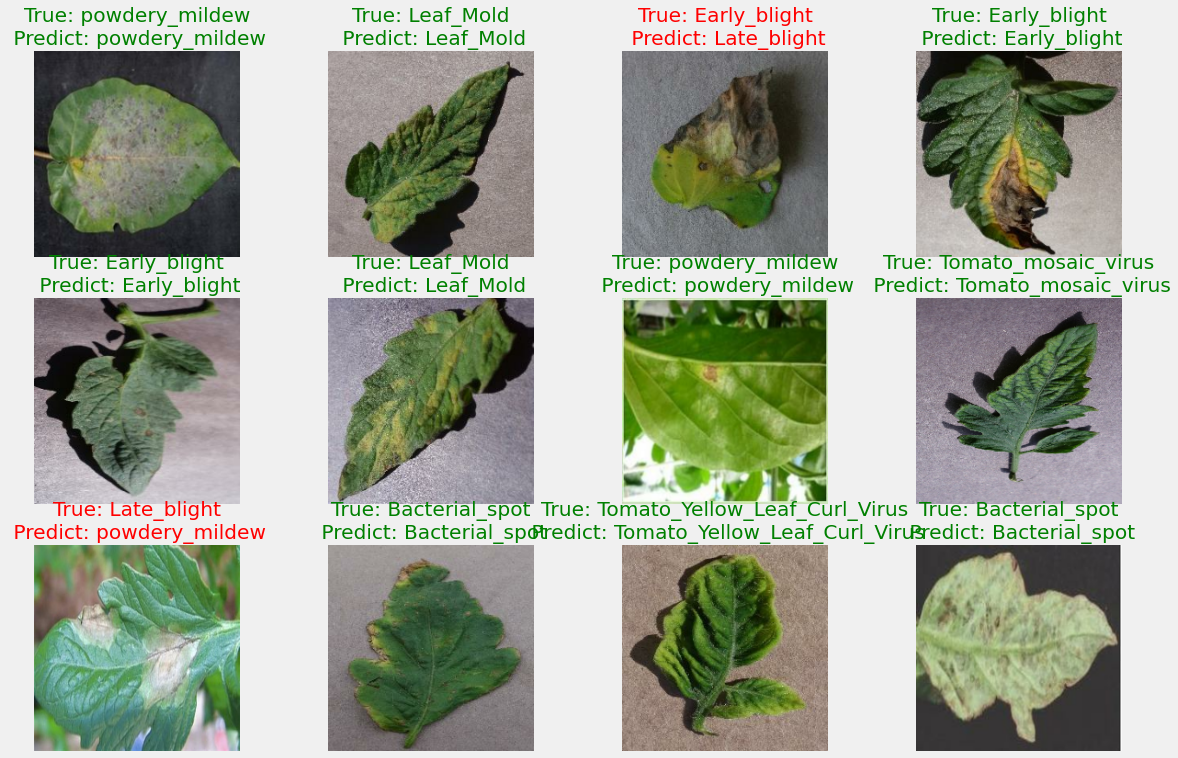

In [ ]:
# error analysis
plt.figure(figsize=(18,12))
for image_batch,label_batch in test_ds.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = test_ds.class_names[np.argmax(label_batch[i])]
        predict_class = test_ds.class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

Save Model

You can save an entire model to a single artifact. It will include:
- The model's architecture/config
- The model's weight values (which were learned during training)
- The model's compilation information (if compile() was called)
- The optimizer and its state, if any (this enables you to restart training where you left)

*Reference*:
- [save and serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [ ]:
# save the model
MODEL_PATH = '/content/gdrive/MyDrive/deep_learning/model/'
MODEL_NAME = "basic_cnn_v1"

model.save(MODEL_PATH + MODEL_NAME)

In [ ]:
# reconstruct the model and make sure it works as expected
reconstructed_model = keras.models.load_model(MODEL_PATH + MODEL_NAME)

In [ ]:
np.testing.assert_allclose(
    model.predict(test_ds), reconstructed_model.predict(test_ds)
)

105/105 [==============================] - 10s 95ms/step


In [ ]:
reconstructed_model.evaluate(test_ds)

# # test loss: 0.25463148951530457; test accuracy: 0.9167165756225586

105/105 [==============================] - 10s 95ms/step - loss: 0.2546 - accuracy: 0.9167


[0.25463148951530457, 0.9167165756225586]

In [ ]:
# terminat the session
from google.colab import runtime
runtime.unassign()

## 4. Basic Custom CNN with Image Augmentation

## 5. Transfer Learning - Pre-trained CNN as a Feature Extractor

## 6. Transfer Learning - Pre-trained CNN as a Feature Extractor with Image Augmentation 